<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/jax_line_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline

from scipy.optimize import minimize

import astropy.units as u
import astropy.constants as const

from jax import jacobian, jit
import jax.numpy as jnp

from itertools import product

import os
import urllib.request

In [3]:
urllib.request.urlretrieve('https://eis.nrl.navy.mil/level1/hdf5/2007/01/18/eis_20070118_181213.data.h5', 'eis_20070118_181213.data.h5')
urllib.request.urlretrieve('https://eis.nrl.navy.mil/level1/hdf5/2007/01/18/eis_20070118_181213.head.h5', 'eis_20070118_181213.head.h5')
os.listdir() 

['.config',
 'eis_20070118_181213.data.h5',
 'eis_20070118_181213.head.h5',
 'sample_data']

In [4]:
! git clone https://github.com/USNavalResearchLaboratory/eispac.git

Cloning into 'eispac'...
remote: Enumerating objects: 1216, done.
remote: Counting objects: 100% (1216/1216), done.
remote: Compressing objects: 100% (788/788), done.
remote: Total 1216 (delta 468), reused 1156 (delta 423), pack-reused 0
Receiving objects: 100% (1216/1216), 42.25 MiB | 27.95 MiB/s, done.
Resolving deltas: 100% (468/468), done.


In [5]:
!python -m pip install eispac/.

Processing ./eispac
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 6.1 MB 7.1 MB/s 
     |████████████████████████████████| 84 kB 5.5 MB/s 
     |████████████████████████████████| 8.3 MB 26.2 MB/s 
     |████████████████████████████████| 1.3 MB 34.0 MB/s 
     |████████████████████████████████| 294 kB 62.3 MB/s 
     |████████████████████████████████| 142 kB 72.5 MB/s 
     |████████████████████████████████| 59.9 MB 35 kB/s 
     |████████████████████████████████| 317 kB 67.7 MB/s 
  Created wheel for eispac: filename=eispac-0.90.50-py3-none-any.whl size=10791050 sha256=39080ae7d7eafd2cf27ea0a8be92c91a59

In [6]:
os.listdir()

['.config',
 'eis_20070118_181213.data.h5',
 'eis_20070118_181213.head.h5',
 'eispac',
 'sample_data']

In [7]:
from eispac import read_cube
path = 'eis_20070118_181213.data.h5'
wave_len = 284

eis_cube = read_cube(path, wave_len)

Data file,
   /content/eis_20070118_181213.data.h5
Header file,
   /content/eis_20070118_181213.head.h5
Found a wavelength 284.00 [Angstroms] in window 8
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


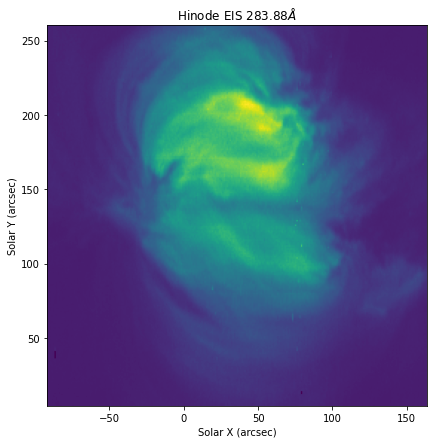

In [8]:
def convert_pix_2_coords(x,y):
    x_coord = (cent_x+(x-crpix_x)*cdelt_x)*deg_2_arcsec
    y_coord = (cent_y+(y-crpix_y)*cdelt_y)*deg_2_arcsec
    
    return x_coord, y_coord
    
ny,nx,nwave = eis_cube.data.shape

cent_wav, cent_x, cent_y = eis_cube.wcs.wcs.crval
cdelt_wav, cdelt_x, cdelt_y = eis_cube.wcs.wcs.cdelt
crpix_wav, crpix_x, crpix_y = eis_cube.wcs.wcs.crpix

deg_2_arcsec = 3600

x_extent, y_extent = convert_pix_2_coords([0,nx],[0,ny])

extent_vec = [x_extent[0],x_extent[1],y_extent[0],y_extent[1]]

plt.figure(figsize=(7,7))
plt.imshow(eis_cube.data[:,:,11], origin='lower', extent=extent_vec)
plt.xlabel('Solar X (arcsec)')
plt.ylabel('Solar Y (arcsec)')
plt.title(r'Hinode EIS {:1.2f}$\AA$'.format(cent_wav));

In [9]:
# Negative log-likelihood

def neg_loglike_jx(theta, x, y, sigma, model):
    """
    Return Gaussian negative log-likelihood for unknown sigma

    Parameters
    ----------
    theta - model parameters, theta[0] should always be the estimate for sigma
    x - 1d array
        x values of data
    y - 1d array
        y values of data
    model - function 
            model to fit to the data
    """
    
    N = len(x)
    mu = model(theta, x)

    # this can be obtained from Equation X in notes
    ll = -jnp.sum(0.5 * jnp.log(2*np.pi*sigma**2)) - \
        (jnp.sum(jnp.square(y - mu)/2/sigma**2))

    return -1 * ll   # note - no factor of 2 here

In [10]:
def single_gauss(p, x):
    # single gaussian plus constant
    # p[2] is 1/e width
    return p[0]*jnp.exp(-(p[1]-x)**2/p[2]**2)+p[3]

def double_gauss(p, x):
    # double gaussian plus constant
    # p[2] & p[6] are 1/e width
    return p[0]*jnp.exp(-(p[1]-x)**2/p[2]**2)+p[3]+p[4]*jnp.exp(-(p[5]-x)**2/p[6]**2)

In [14]:
jac = jacobian(neg_loglike_jx)
jit_log = jit(neg_loglike_jx, static_argnums=(4,)) #add static argument for model
jit_jac = jit(jac, static_argnums=(4,))

In [27]:
ny,nx,nwave = eis_cube.data.shape

log_lik = np.zeros((ny,nx))


inten = jnp.array(eis_cube.data.copy())
wav = jnp.array(eis_cube.wavelength.copy())
errs = jnp.array(eis_cube.uncertainty.array.copy())

mid_wav = wav[:,:,11]
wav_cent = wav-mid_wav[:,:, jnp.newaxis]
    
# scale data
inten_max = inten.max(axis=2)
inten_sc = inten/inten_max[:,:,jnp.newaxis]
errs_sc  = errs/inten_max[:,:,jnp.newaxis]


In [43]:
sg_fit = np.zeros((ny,nx,4))
for i, j in product(np.arange(0,10), np.arange(0,10)):
    
    x = wav_cent[j,i,:]
    y = inten_sc[j,i,:]
    y_err = errs_sc[j,i,:]
    
    guess_vals_sg = jnp.array([y.max(), 
                              x[11], 
                              0.01, 
                              y.min()], dtype='float32')
    
    res = minimize(jit_log, guess_vals_sg, method='BFGS',jac=jit_jac,
                   args=(x, y, y_err, single_gauss))
    
    sg_fit[j,i,:] = res.x

In [41]:
guess_vals_sg

DeviceArray([1.  , 0.  , 0.01, 0.  ], dtype=float32)